# 2D Interpolation Algorithms

- **Nearest Neighbor**: Simple, fast, but low quality.
- **Bilinear**: Smooth, uses 4 points, better quality than nearest neighbor.
- **Bicubic**: High-quality, uses 16 points, computationally expensive.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## # Nearest Neighbor Interpolation

#### **Principle**:

Nearest Neighbor Interpolation is the simplest interpolation method. It assigns the value of the nearest known data point to the new point. Mathematically, for a new point $(x, y)$, the interpolated value $Z(x, y)$ is the value of the closest grid point $(x_i, y_j)$ in the original data.

#### **Formula**:

$$
Z(x, y) = Z(x_i, y_j)
$$

where:
$$
(x_i, y_j) = \arg\min_{(x_k, y_l)} \sqrt{(x - x_k)^2 + (y - y_l)^2}
$$

#### **Implementation**:

1. For each new point $(x, y)$, find the closest grid point $(x_i, y_j)$ in the original data.
2. Assign $Z(x, y) = Z(x_i, y_j)$.

In [2]:
def nearest_neighbor_interpolation(x_sample, y_sample, z_sample, X_new, Y_new):
    Z_new = np.zeros_like(X_new)
    for i in range(X_new.shape[0]):
        for j in range(X_new.shape[1]):
            distances = np.sqrt((x_sample - X_new[i, j])**2 + (y_sample - Y_new[i, j])**2)
            nearest_idx = np.argmin(distances)
            Z_new[i, j] = z_sample[nearest_idx]
    return Z_new

## # Bilinear Interpolation

#### **Principle**:

Bilinear Interpolation uses linear interpolation in two dimensions. It considers the four nearest grid points surrounding the new point $(x, y)$ and computes a weighted average of their values. The weights are determined by the distances to the neighboring points.

#### **Formula**:

For a new point $(x, y)$, find the four surrounding grid points:

$$
(x_1, y_1), (x_1, y_2), (x_2, y_1), (x_2, y_2)
$$

where:

$$
x_1 \leq x \leq x_2 \quad \text{and} \quad y_1 \leq y \leq y_2
$$

Compute the weights:

$$
dx = \frac{x - x_1}{x_2 - x_1}, \quad dy = \frac{y - y_1}{y_2 - y_1}
$$

The interpolated value is:

$$
Z(x, y) = (1 - dx)(1 - dy) \cdot Z(x_1, y_1) + dx(1 - dy) \cdot Z(x_2, y_1) + (1 - dx)dy \cdot Z(x_1, y_2) + dx \cdot dy \cdot Z(x_2, y_2)
$$

#### **Implementation**:

1. For each new point $(x, y)$, find the four surrounding grid points.
2. Compute the weights $dx$ and $dy$.
3. Perform a weighted average of the four grid points' values.

In [3]:
def bilinear_interpolation(x_sample, y_sample, z_sample, X_new, Y_new):
    Z_new = np.zeros_like(X_new)
    for i in range(X_new.shape[0]):
        for j in range(X_new.shape[1]):
            x_idx = np.searchsorted(x_sample, X_new[i, j]) - 1
            x_idx = np.clip(x_idx, 0, len(x_sample) - 2)
            y_idx = np.searchsorted(y_sample, Y_new[i, j]) - 1
            y_idx = np.clip(y_idx, 0, len(y_sample) - 2)
            x1, x2 = x_sample[x_idx], x_sample[x_idx + 1]
            y1, y2 = y_sample[y_idx], y_sample[y_idx + 1]
            Q11 = z_sample[y_idx, x_idx]
            Q12 = z_sample[y_idx, x_idx + 1]
            Q21 = z_sample[y_idx + 1, x_idx]
            Q22 = z_sample[y_idx + 1, x_idx + 1]
            dx = (X_new[i, j] - x1) / (x2 - x1)
            dy = (Y_new[i, j] - y1) / (y2 - y1)
            Z_new[i, j] = (Q11 * (1 - dx) * (1 - dy) +
                          Q12 * dx * (1 - dy) +
                          Q21 * (1 - dx) * dy +
                          Q22 * dx * dy)
    return Z_new

## # Bicubic Interpolation

#### **Principle**:

Bicubic Interpolation uses cubic polynomials to approximate the surface between grid points. It considers a 4x4 neighborhood (16 points) around the new point $(x, y)$ and computes a weighted sum of their values. The weights are determined by cubic basis functions (e.g., Catmull-Rom splines).

#### **Formula**:

For a new point $(x, y)$, find the 4x4 grid points:

$$
(x_{i-1}, y_{j-1}), (x_{i-1}, y_j), (x_{i-1}, y_{j+1}), (x_{i-1}, y_{j+2}), \dots, (x_{i+2}, y_{j+2})
$$

Compute the weights using cubic basis functions:

$$
w(t) = \begin{cases}
(1.5t^3 - 2.5t^2 + 1) & \text{if } 0 \leq t < 1, \\
(-0.5t^3 + 2.5t^2 - 4t + 2) & \text{if } 1 \leq t < 2, \\
0 & \text{otherwise}.
\end{cases}
$$

The interpolated value is:

$$
Z(x, y) = \sum_{k=-1}^2 \sum_{l=-1}^2 w\left(\frac{x - x_{i+k}}{x_{i+1} - x_i}\right) \cdot w\left(\frac{y - y_{j+l}}{y_{j+1} - y_j}\right) \cdot Z(x_{i+k}, y_{j+l})
$$

#### **Implementation**:

1. For each new point $(x, y)$, find the 4x4 neighborhood of grid points.
2. Compute the weights using cubic basis functions.
3. Perform a weighted sum of the 16 grid points' values.

In [4]:
def cubic_weights(t):
    w0 = (-0.5 * t**3) + (1.0 * t**2) + (-0.5 * t)
    w1 = (1.5 * t**3) + (-2.5 * t**2) + 1.0
    w2 = (-1.5 * t**3) + (2.0 * t**2) + (0.5 * t)
    w3 = (0.5 * t**3) + (-0.5 * t**2)
    return [w0, w1, w2, w3]

def bicubic_interpolation(x_sample, y_sample, z_sample, X_new, Y_new):
    Z_new = np.zeros_like(X_new)
    for i in range(X_new.shape[0]):
        for j in range(X_new.shape[1]):
            x = X_new[i, j]
            y = Y_new[i, j]

            x_idx = np.searchsorted(x_sample, x) - 1
            x_idx = np.clip(x_idx, 0, len(x_sample) - 2)
            x_indices = [x_idx - 1, x_idx, x_idx + 1, x_idx + 2]
            x_indices = np.clip(x_indices, 0, len(x_sample) - 1)

            y_idx = np.searchsorted(y_sample, y) - 1
            y_idx = np.clip(y_idx, 0, len(y_sample) - 2)
            y_indices = [y_idx - 1, y_idx, y_idx + 1, y_idx + 2]
            y_indices = np.clip(y_indices, 0, len(y_sample) - 1)

            x_left = x_sample[x_idx]
            x_right = x_sample[x_idx + 1]
            dx = (x - x_left) / (x_right - x_left) if (x_right != x_left) else 0.0

            y_left = y_sample[y_idx]
            y_right = y_sample[y_idx + 1]
            dy = (y - y_left) / (y_right - y_left) if (y_right != y_left) else 0.0

            z_values = np.zeros((4, 4))
            for ky in range(4):
                for kx in range(4):
                    z_values[ky, kx] = z_sample[y_indices[ky], x_indices[kx]]

            wx = cubic_weights(dx)
            wy = cubic_weights(dy)

            z_interp = 0.0
            for ky in range(4):
                for kx in range(4):
                    z_interp += wx[kx] * wy[ky] * z_values[ky, kx]

            Z_new[i, j] = z_interp

    return Z_new

## # Example

$$
f(x,y)=\sin(x^2+y^2)
$$

In [5]:
def complex_function(x, y):
    return np.sin(np.sqrt(x**2 + y**2))

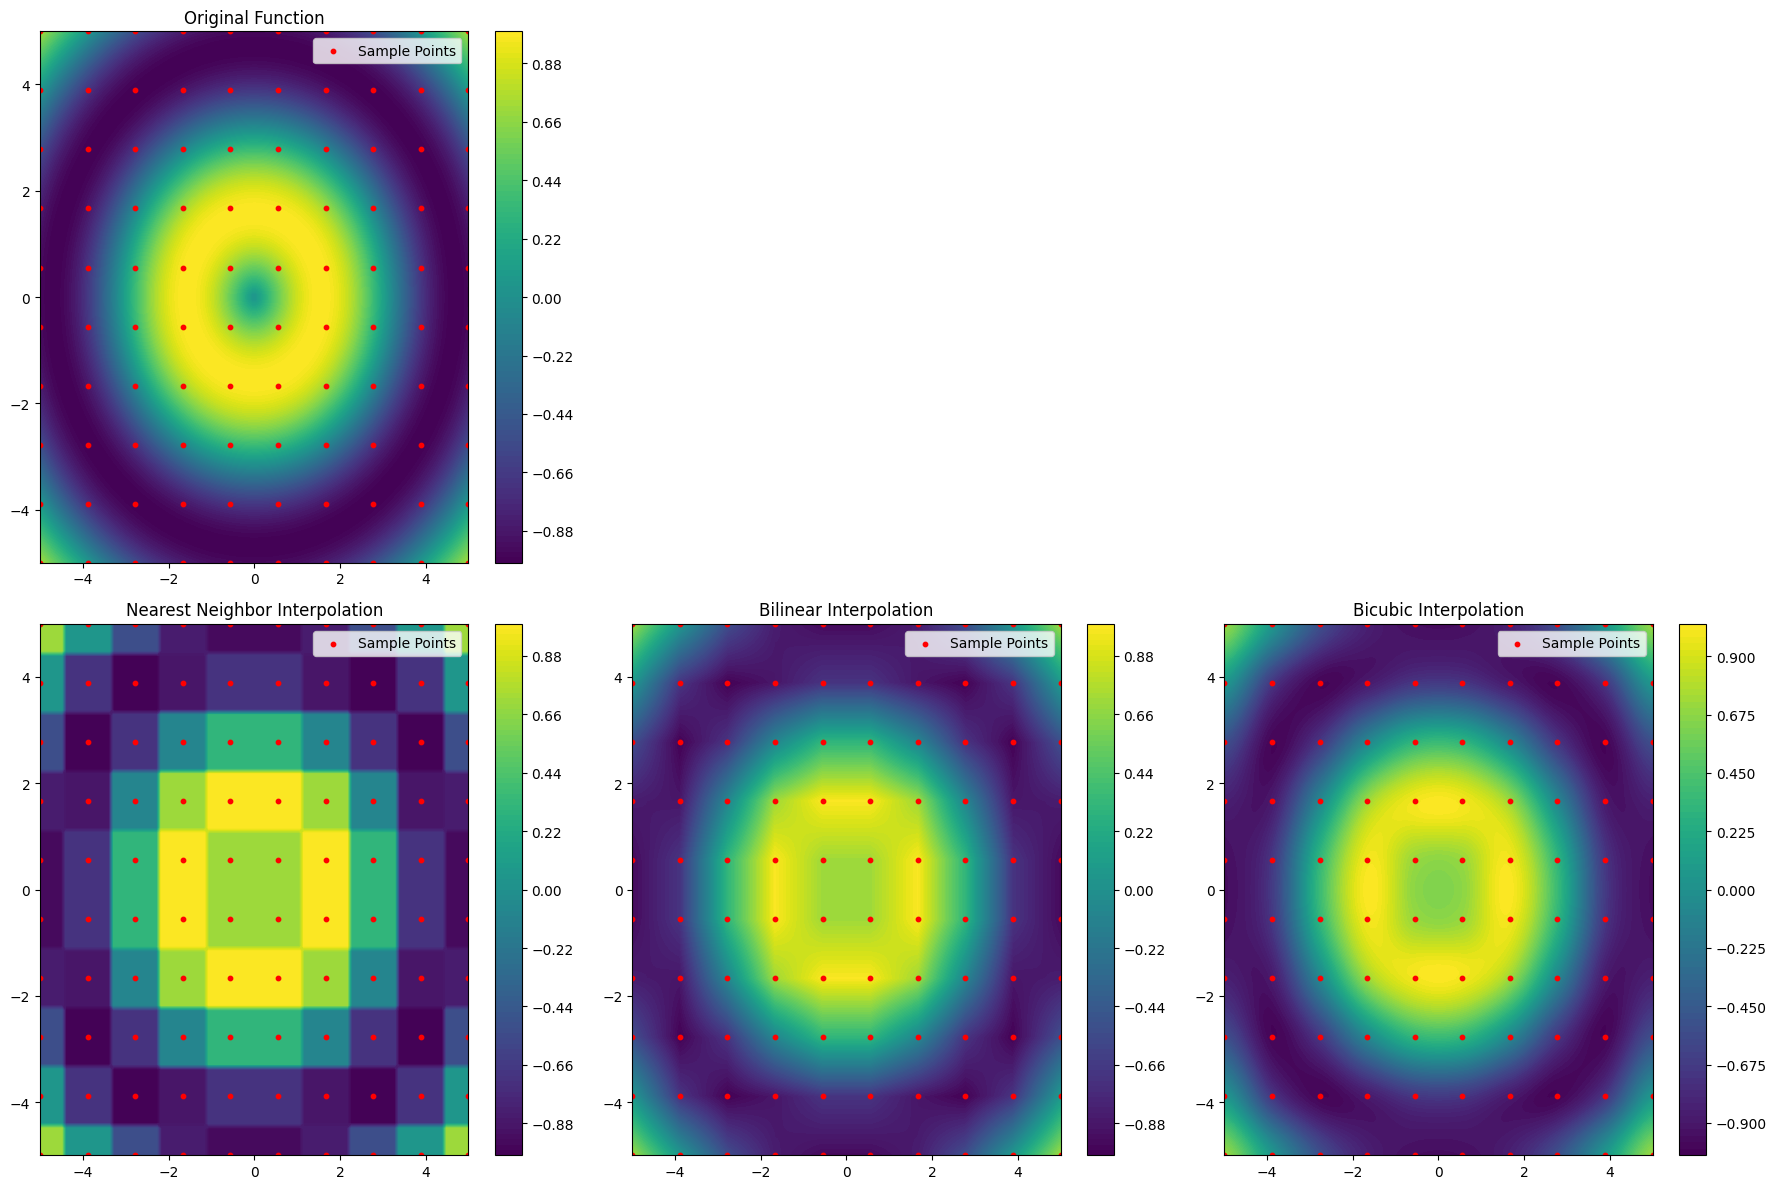

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def complex_function(x, y):
    return np.sin(np.sqrt(x**2 + y**2))

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = complex_function(X, Y)

x_sample_grid = np.linspace(-5, 5, 10)
y_sample_grid = np.linspace(-5, 5, 10)
X_sample, Y_sample = np.meshgrid(x_sample_grid, y_sample_grid)
Z_sample = complex_function(X_sample, Y_sample)

x_samples_flat = X_sample.flatten()
y_samples_flat = Y_sample.flatten()
z_samples_flat = Z_sample.flatten()

x_new = np.linspace(-5, 5, 100)
y_new = np.linspace(-5, 5, 100)
X_new, Y_new = np.meshgrid(x_new, y_new)


Z_nn = nearest_neighbor_interpolation(x_samples_flat, y_samples_flat, z_samples_flat, X_new, Y_new)
Z_linear = bilinear_interpolation(x_sample_grid, y_sample_grid, Z_sample, X_new, Y_new)
Z_cubic = bicubic_interpolation(x_sample_grid, y_sample_grid, Z_sample, X_new, Y_new)

plt.figure(figsize=(18, 12))

# Original
plt.subplot(2, 3, 1)
plt.contourf(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar()
plt.title("Original Function")
plt.scatter(X_sample.flatten(), Y_sample.flatten(), c='red', s=10, label='Sample Points')
plt.legend()

# Nearest Neighbor Interpolation
plt.subplot(2, 3, 4)
plt.contourf(X_new, Y_new, Z_nn, levels=100, cmap='viridis')
plt.colorbar()
plt.title("Nearest Neighbor Interpolation")
plt.scatter(X_sample.flatten(), Y_sample.flatten(), c='red', s=10, label='Sample Points')
plt.legend()

# Bilinear Interpolation
plt.subplot(2, 3, 5)
plt.contourf(X_new, Y_new, Z_linear, levels=100, cmap='viridis')
plt.colorbar()
plt.title("Bilinear Interpolation")
plt.scatter(X_sample.flatten(), Y_sample.flatten(), c='red', s=10, label='Sample Points')
plt.legend()

# Bicubic Interpolation
plt.subplot(2, 3, 6)
plt.contourf(X_new, Y_new, Z_cubic, levels=100, cmap='viridis')
plt.colorbar()
plt.title("Bicubic Interpolation")
plt.scatter(X_sample.flatten(), Y_sample.flatten(), c='red', s=10, label='Sample Points')
plt.legend()

plt.tight_layout()
plt.show()

## # Scipy Version(By Qwen)

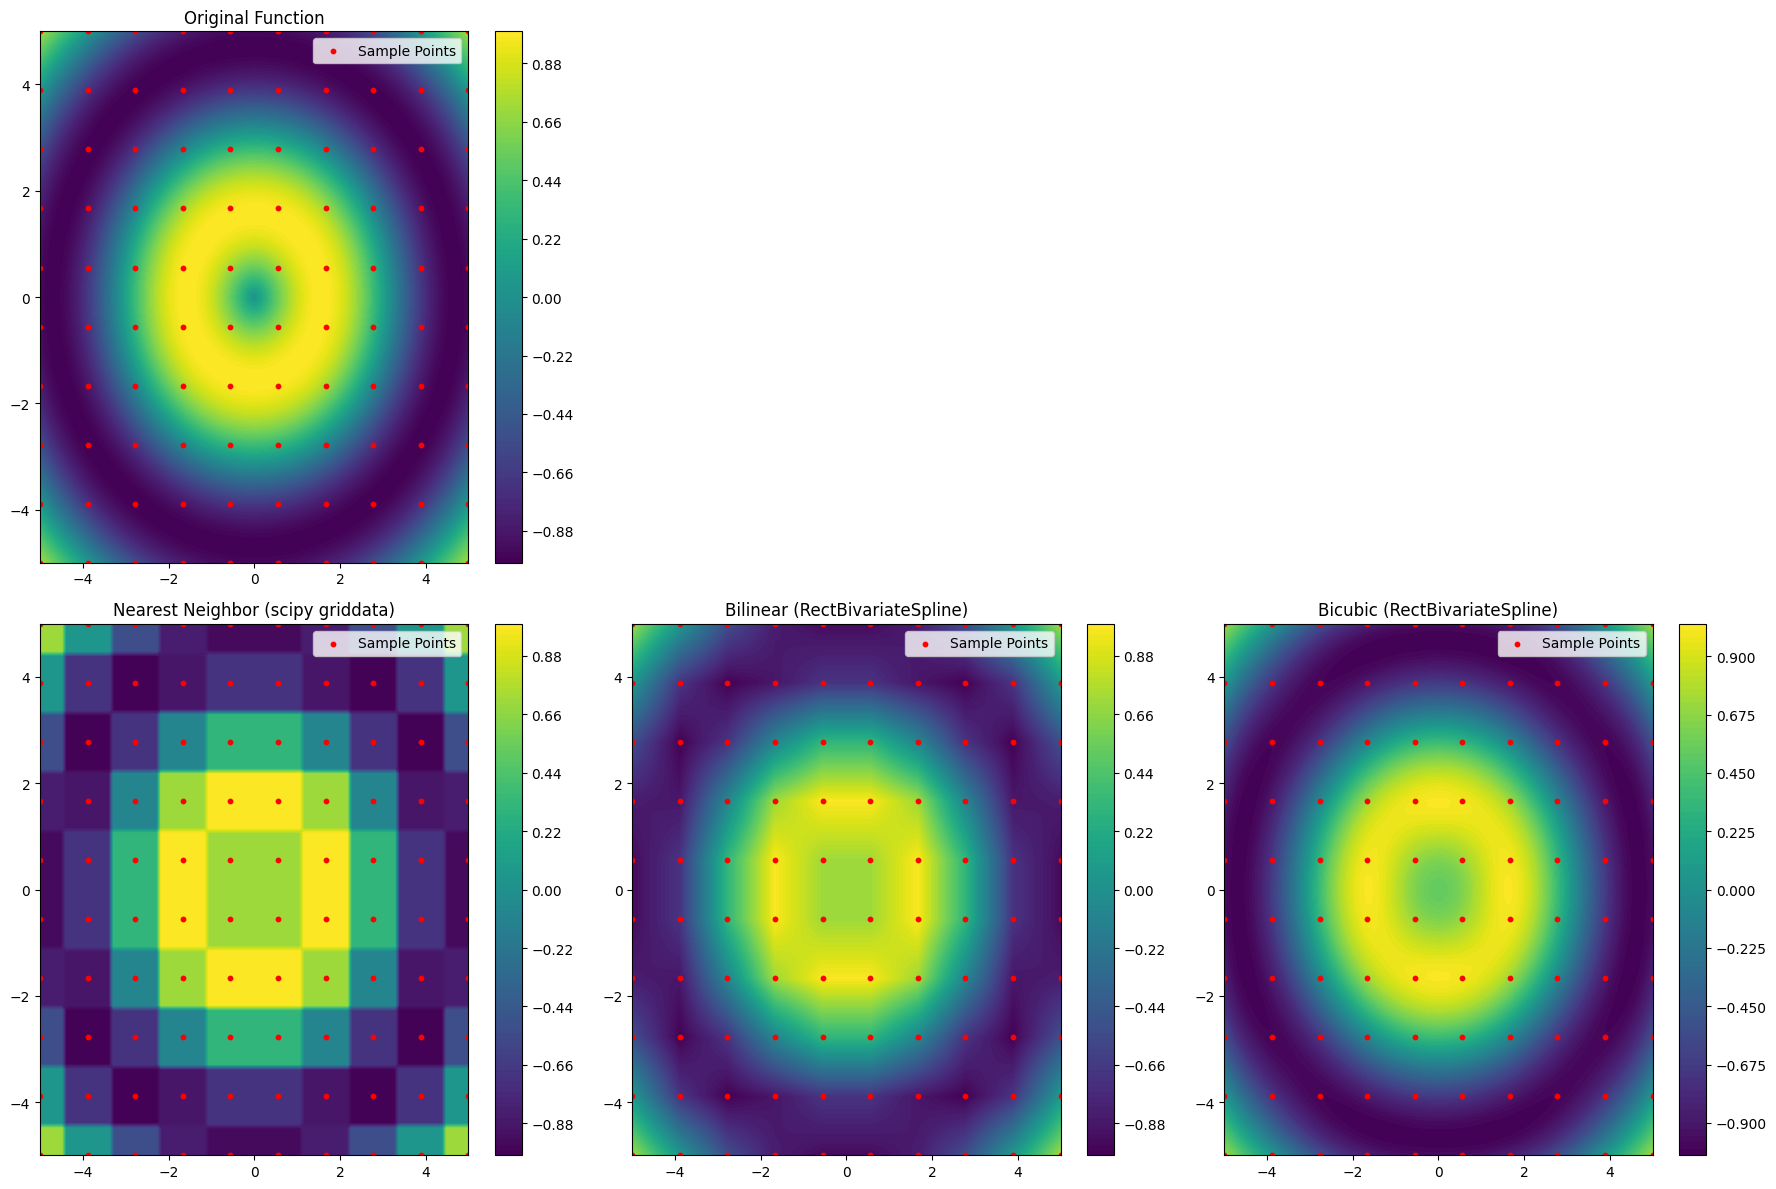

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, RectBivariateSpline

# 定义复杂二维函数
def complex_function(x, y):
    return np.sin(np.sqrt(x**2 + y**2))

# 生成网格数据
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = complex_function(X, Y)

# 生成网格样本点
x_sample_grid = np.linspace(-5, 5, 10)
y_sample_grid = np.linspace(-5, 5, 10)
X_sample, Y_sample = np.meshgrid(x_sample_grid, y_sample_grid)
Z_sample = complex_function(X_sample, Y_sample)

# 展平网格样本点用于插值
points = np.vstack((X_sample.flatten(), Y_sample.flatten())).T
values = Z_sample.flatten()

# 定义插值点
x_new = np.linspace(-5, 5, 100)
y_new = np.linspace(-5, 5, 100)
X_new, Y_new = np.meshgrid(x_new, y_new)

# 使用 scipy 的 griddata 进行最近邻、线性和三次插值
Z_nn_scipy = griddata(points, values, (X_new, Y_new), method='nearest')
Z_linear_scipy = griddata(points, values, (X_new, Y_new), method='linear')
Z_cubic_scipy = griddata(points, values, (X_new, Y_new), method='cubic')

# 使用 RectBivariateSpline 进行双线性和双三次插值
spline_linear = RectBivariateSpline(x_sample_grid, y_sample_grid, Z_sample, kx=1, ky=1)  # 线性插值
Z_linear_spline = spline_linear(x_new, y_new)

spline_cubic = RectBivariateSpline(x_sample_grid, y_sample_grid, Z_sample, kx=3, ky=3)  # 三次插值
Z_cubic_spline = spline_cubic(x_new, y_new)

# 可视化
plt.figure(figsize=(18, 12))

# 原始函数
plt.subplot(2, 3, 1)
plt.contourf(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar()
plt.title("Original Function")
plt.scatter(X_sample.flatten(), Y_sample.flatten(), c='red', s=10, label='Sample Points')
plt.legend()

# 最近邻插值 (scipy griddata)
plt.subplot(2, 3, 4)
plt.contourf(X_new, Y_new, Z_nn_scipy, levels=100, cmap='viridis')
plt.colorbar()
plt.title("Nearest Neighbor (scipy griddata)")
plt.scatter(X_sample.flatten(), Y_sample.flatten(), c='red', s=10, label='Sample Points')
plt.legend()

# 双线性插值 (RectBivariateSpline)
plt.subplot(2, 3, 5)
plt.contourf(X_new, Y_new, Z_linear_spline, levels=100, cmap='viridis')
plt.colorbar()
plt.title("Bilinear (RectBivariateSpline)")
plt.scatter(X_sample.flatten(), Y_sample.flatten(), c='red', s=10, label='Sample Points')
plt.legend()

# 双三次插值 (RectBivariateSpline)
plt.subplot(2, 3, 6)
plt.contourf(X_new, Y_new, Z_cubic_spline, levels=100, cmap='viridis')
plt.colorbar()
plt.title("Bicubic (RectBivariateSpline)")
plt.scatter(X_sample.flatten(), Y_sample.flatten(), c='red', s=10, label='Sample Points')
plt.legend()

plt.tight_layout()
plt.show()